## Import TensorFlow and other libraries

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset
To start, you will train the basic autoencoder using the Fashon MNIST dataset. Each image in this dataset is 28x28 pixels. 

In [22]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [50]:
latent_dim = 10 
size_image = 28

class Autoencoder(Model):
  def __init__(self, latent_dim, size_image):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation='sigmoid'),
      layers.Dense(64, activation='sigmoid'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation='sigmoid'),
      layers.Dense(128, activation='sigmoid'),
      layers.Dense(size_image * size_image, activation='sigmoid'),
      layers.Reshape((size_image, size_image))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim, size_image) 

In [51]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [52]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0538 - val_loss: 0.0372
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0344 - val_loss: 0.0321
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0307 - val_loss: 0.0295
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0279 - val_loss: 0.0265
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0257 - val_loss: 0.0252
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0248 - val_loss: 0.0246
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0241 - val_loss: 0.0240
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0236 - val_loss: 0.0236
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0232 - val_loss: 0.0232
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.022

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [53]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

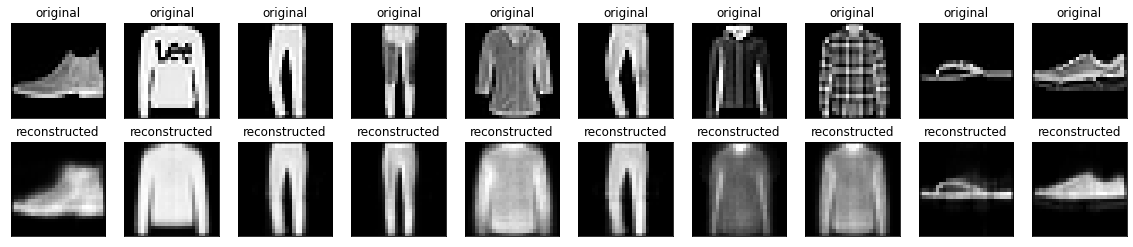

In [54]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [55]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [56]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [57]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

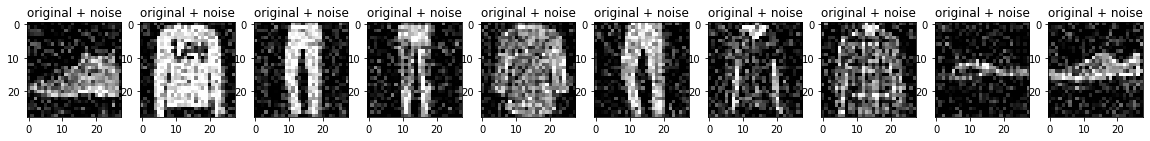

In [58]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [93]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), 
      layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(128, (3,3), activation='relu', padding='valid', strides=2),
      layers.Conv2D(10, (3,3), activation='relu', padding='valid', strides=2)])
    
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(10, kernel_size=3, strides=2, activation='relu', padding='valid'),
      layers.Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='valid'),
      layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [94]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [95]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 83s 44ms/step - loss: 0.0251 - val_loss: 0.0192
Epoch 2/10
1875/1875 [==============================] - 82s 44ms/step - loss: 0.0174 - val_loss: 0.0170
Epoch 3/10
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0162 - val_loss: 0.0159
Epoch 4/10
1875/1875 [==============================] - 83s 44ms/step - loss: 0.0156 - val_loss: 0.0154
Epoch 5/10
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0151 - val_loss: 0.0151
Epoch 6/10
1875/1875 [==============================] - 82s 44ms/step - loss: 0.0147 - val_loss: 0.0149
Epoch 7/10
1875/1875 [==============================] - 80s 43ms/step - loss: 0.0145 - val_loss: 0.0144
Epoch 8/10
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0142 - val_loss: 0.0144
Epoch 9/10
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0141 - val_loss: 0.0140
Epoch 10/10
1875/1875 [==============================] - 81s 43m

In [96]:
autoencoder.encoder.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 1, 1, 10)          11530     
Total params: 104,202
Trainable params: 104,202
Non-trainable params: 0
_________________________________________________________________


The decoder upsamples the images back from 7x7 to 28x28.

In [97]:
autoencoder.decoder.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_17 (Conv2DT (None, 3, 3, 10)          910       
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 7, 7, 128)         11648     
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 14, 14, 64)        73792     
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 1)         289       
Total params: 105,103
Trainable params: 105,103
Non-trainable params: 0
_________________________________________________________________


Plotting both the noisy images and the denoised images produced by the autoencoder.

In [98]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [99]:
encoded_imgs[0].shape

(1, 1, 10)

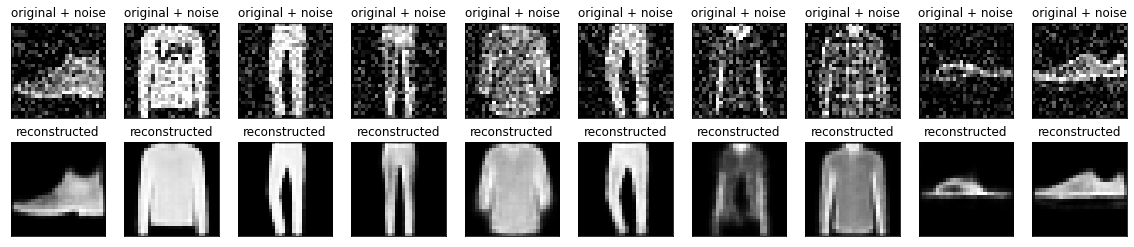

In [100]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [20]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [21]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [22]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [23]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG. 

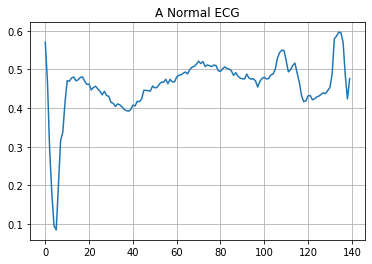

In [24]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

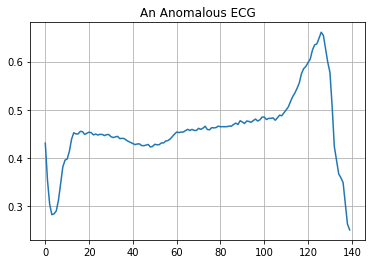

In [25]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [26]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [27]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [28]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 38ms/step - loss: 0.0580 - val_loss: 0.0531
Epoch 2/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0561 - val_loss: 0.0512
Epoch 3/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0530 - val_loss: 0.0500
Epoch 4/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0495 - val_loss: 0.0480
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0457 - val_loss: 0.0460
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0420 - val_loss: 0.0438
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0388 - val_loss: 0.0423
Epoch 8/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0359 - val_loss: 0.0409
Epoch 9/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0336 - val_loss: 0.0401
Epoch 10/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0315 - val_loss: 0.0392
Epoch 11/20
5/5 [============

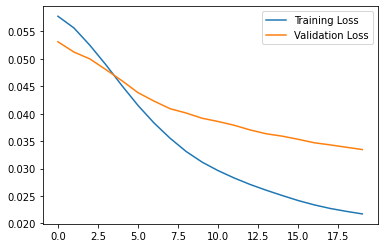

In [29]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

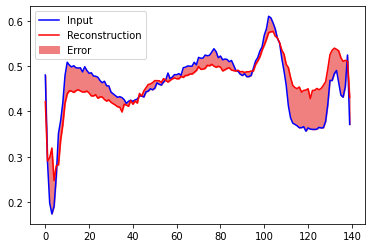

In [30]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

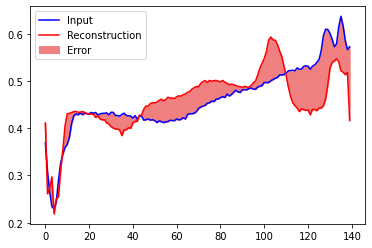

In [31]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

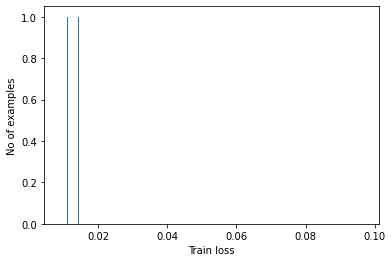

In [32]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [33]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032926645


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial. 

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier. 

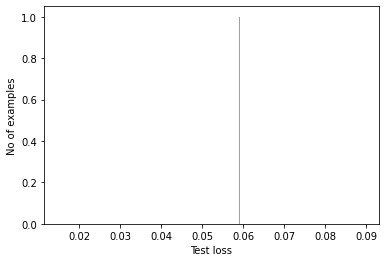

In [34]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [35]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [36]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571


## Next steps

To learn more about anomaly detection with autoencoders, check out this excellent [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia. For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow. To learn more about the basics, consider reading this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet. For more details, check out chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.
